In [2]:
!pip install kagglehub scikit-learn matplotlib opencv-python seaborn


In [3]:
import os
import cv2
import numpy as np

dataset_path = 'flowers_dataset/flowers'

categories = os.listdir(dataset_path)
data = []
labels = []

for idx, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (64, 64))  # Resize images to 64x64
                data.append(img)
                labels.append(idx)  # Use category index as label
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

data = np.array(data)
labels = np.array(labels)

print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")


Data shape: (4317, 64, 64, 3), Labels shape: (4317,)


In [4]:
from skimage.feature import hog

# Extract HOG features and color histograms
def extract_features(images):
    hog_features = []
    color_features = []

    for img in images:
        # Convert to grayscale for HOG
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hog_feat = hog(
            gray_img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )

        # Calculate color histogram
        color_hist = cv2.calcHist([img], [0, 1, 2], None, [32, 32, 32], [0, 256, 0, 256, 0, 256]).flatten()

        # Append features
        hog_features.append(hog_feat)
        color_features.append(color_hist)

    # Combine HOG and color features
    combined_features = np.hstack((hog_features, color_features))
    return combined_features

features = extract_features(data)
print(f"Extracted Features shape: {features.shape}")


Extracted Features shape: (4317, 34532)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (3453, 34532), Test shape: (864, 34532)


In [6]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust number of components to reduce dimensionality
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Reduced Train shape: {X_train_pca.shape}, Test shape: {X_test_pca.shape}")


Reduced Train shape: (3453, 100), Test shape: (864, 100)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# Train logistic regression model
log_reg_model = LogisticRegression(
    max_iter=1000,  # Increase iteration for convergence
    class_weight='balanced',  # Handle class imbalance
    solver='lbfgs',  # Use the L-BFGS solver for optimization
    C=1.0  # Regularization strength (tune this hyperparameter)
)
log_reg_model.fit(X_train_pca, y_train)

# Make predictions
y_pred = log_reg_model.predict(X_test_pca)

# Calculate Log Loss
y_pred_probs = log_reg_model.predict_proba(X_test_pca)
loss = log_loss(y_test, y_pred_probs)

print(f"Log Loss: {loss:.4f}")


Log Loss: 1.2062


Accuracy: 0.5995370370370371
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.69      0.56       153
           1       0.65      0.58      0.61       210
           2       0.59      0.52      0.55       157
           3       0.61      0.66      0.63       147
           4       0.71      0.58      0.64       197

    accuracy                           0.60       864
   macro avg       0.61      0.60      0.60       864
weighted avg       0.61      0.60      0.60       864



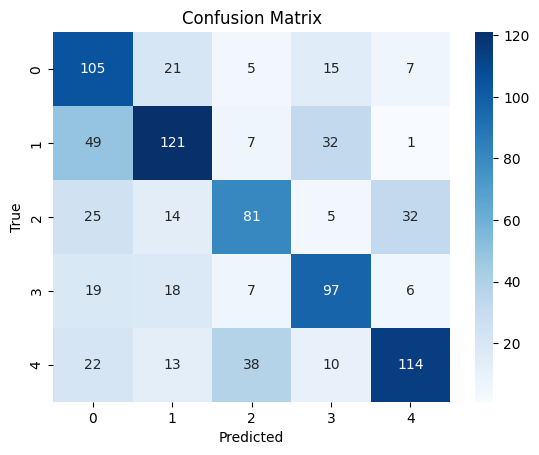

In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


ROC AUC: 0.83


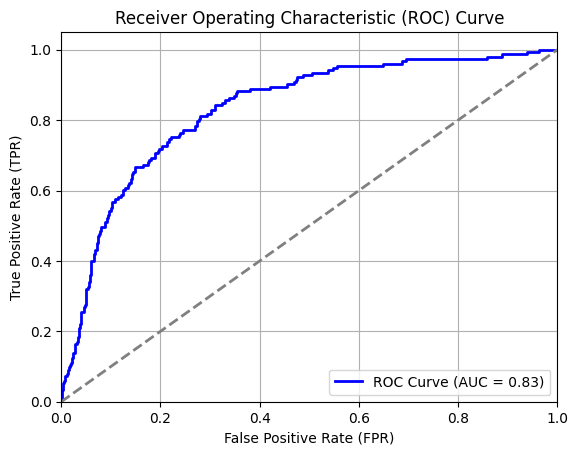

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Convert labels to binary for one class (e.g., class 0 vs. rest)
y_test_binary = label_binarize(y_test, classes=np.unique(labels))
y_pred_probs = log_reg_model.predict_proba(X_test_pca)

# Calculate ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_binary[:, 0], y_pred_probs[:, 0])
roc_auc = auc(fpr, tpr)

# Print AUC Value
print(f"ROC AUC: {roc_auc:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()



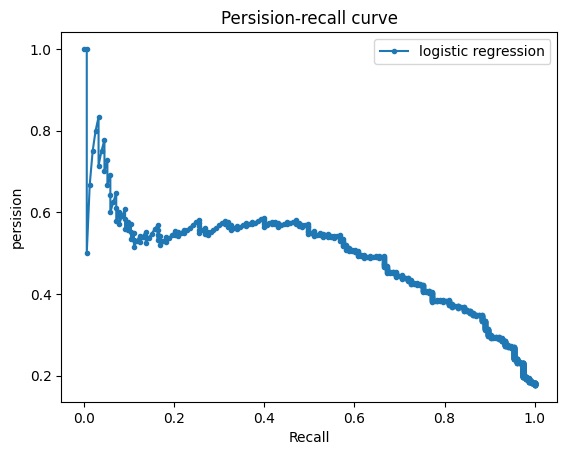

In [15]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test_binary[:,0], y_pred_probs[:,0])
plt.plot(recall, precision,marker='.',label='logistic regression')
plt.xlabel("Recall")
plt.ylabel("persision")
plt.title("Persision-recall curve")
plt.legend()
plt.show()
